# Predicting Bike Rentals

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which I'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day.

In this project, I'll try to predict the total number of bikes people rented in a given hour. I'll predict the 'cnt' column using all of the other columns, except for 'casual' and 'registered'. To accomplish this, I'll create a few different machine learning models and evaluate their performance.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpl_patches
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
plt.style.use('seaborn-whitegrid')
%matplotlib inline

df = pd.read_csv('/Users/miesner.jacob/Desktop/DataQuest/datasets/Bike-Sharing-Dataset/hour.csv')

//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data Exploration

In [3]:
#Validating I have the right dataset
df.shape

(17379, 17)

In [4]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [5]:
df.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

Looking at distribtion of hourly rentals

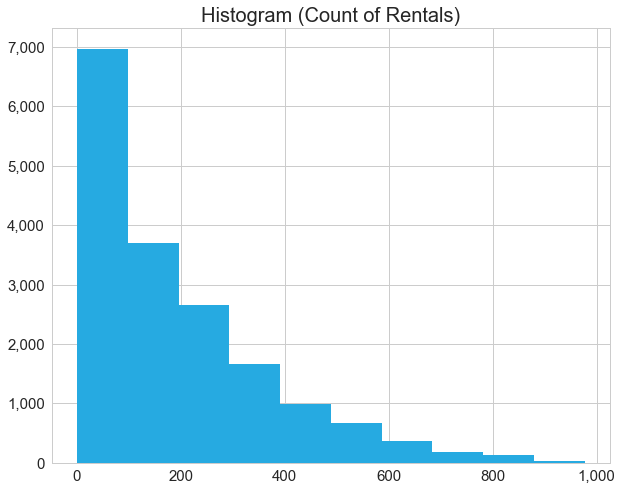

<Figure size 576x576 with 0 Axes>

In [6]:
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(df['cnt'], color = '#26aae1')
ax.set_title('Histogram (Count of Rentals)', size = 20)
plt.figure(figsize=(8,8))
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.yaxis.set_tick_params(labelsize=15)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.show()

In [7]:
#average target value

df['cnt'].mean()

189.46308763450142

Looking at colinearity of attributes

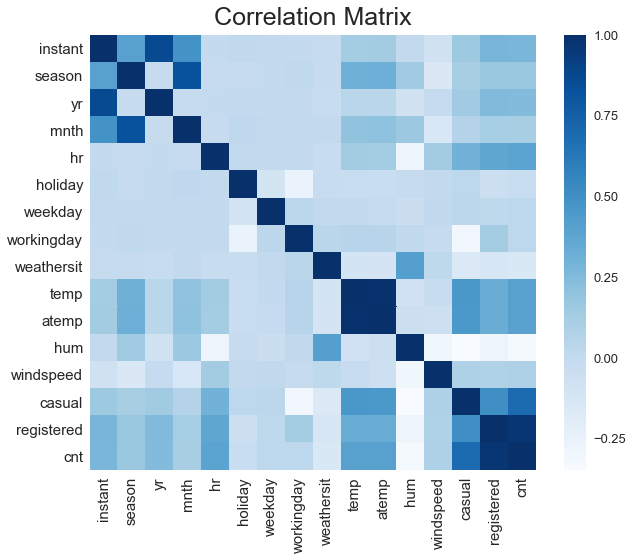

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('Correlation Matrix', size = 25, pad = 10)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
corrmatrix = df.corr()
sns.heatmap(corrmatrix, ax = ax, cmap = 'Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
plt.show()

In [9]:
correls = df.corr()['cnt'].drop('cnt',axis = 0)
correls.sort_values(ascending = False)

registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

Absolute correlations with the target variable

In [10]:
abs_correls = abs(correls)
abs_correls.sort_values(ascending = False)

registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

In [3]:
ProfileReport(df, title='Pandas Profiling Report')

## Feature Engineering, Feature Selection, Feature Preparation

Creating new variables to help with prediction, finding useless and non helpful variables to remove to reduce model noise.

In [12]:
def assign_label(col):
        if col in [6,7,8,9,10,11]:
            col = 1
        elif col in [12,13,14,15,16,17]:
            col = 2
        elif col in [18,19,20,21,22,23,24]:
            col = 3
        elif col in [0,1,2,3,4,5]:
            col = 4
        return col
            
df['time_label']= df['hr'].apply(assign_label)

Normalizing numerical attributes to have attributes to prevent their  uneven distributions from skewing model learning

In [13]:
#Normalizing Numerical Columns

numeric_cols = df.select_dtypes(include=['int', 'float']).drop('cnt', axis = 1)
numeric_cols = numeric_cols.columns
df[numeric_cols] = df[numeric_cols].astype(float)
df[numeric_cols] = df[numeric_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

#### Defining Traing Test Split for Feature Selection and Modeling

Creating split

In [14]:
for_split = df.sample(frac = 1)
cutoff = int((for_split.shape[0] * 0.8))

train = for_split[:cutoff]
test = for_split[cutoff:]

features = df.drop(['cnt','casual','dteday','registered'], axis = 1).columns
target = 'cnt'

In [15]:
#Listing features with high Varitation Inflation Factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df[numeric_cols].values, i) for i in range(df[numeric_cols].shape[1])]
vif["Features"] = df[numeric_cols].columns

high_vif_features = vif[vif['VIF Factor'] <= 10]['Features'].to_list()
print(high_vif_features)

#df.drop(high_vif_features, axis = 1)

['season', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'windspeed', 'casual', 'registered', 'time_label']


In [16]:
# Using Lasso Regression for Feature Selection
lassor = Lasso(random_state = 1)
lassor.fit(train[features], train[target])

coef_list = []
feat_list = []
for coef, feat in zip(lassor.coef_,train[features]):
    coef_list.append(coef)
    feat_list.append(feat)
    
coefs = pd.DataFrame()
coefs['Features'] = feat_list
coefs['Coefficients'] = coef_list

In [17]:
#Listing columns with low regression coefficient with target variable

no_correlation_features = coefs[coefs['Coefficients'] == 0]['Features'].to_list()
# df = df.drop(no_correlation_features, axis = 1)

print(no_correlation_features)

['instant', 'mnth', 'holiday', 'atemp', 'windspeed']


## Selecting an Error Metric

Since I am working with continuous data here I will a combination of RMSE and R2 for my evalutation of model performance. MSE is also a good candidate but the scaling of RMSE helps compare our error to the target value better.

## Modeling!

### Linear Regression

In [18]:
lr = LinearRegression()
lr.fit(train[features], train[target])
lr_predictions = lr.predict(test[features])
lr_r2 = r2_score(test[target], lr_predictions)
lr_mse = mean_squared_error(test[target], lr_predictions)
lr_rmse = int(lr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(lr_r2)))
print("MSE: " + str("{:,.0f}".format(lr_mse)))
print("RMSE: " + str("{:,.0f}".format(lr_rmse)))

R2: 47.12%
MSE: 16,860
RMSE: 129


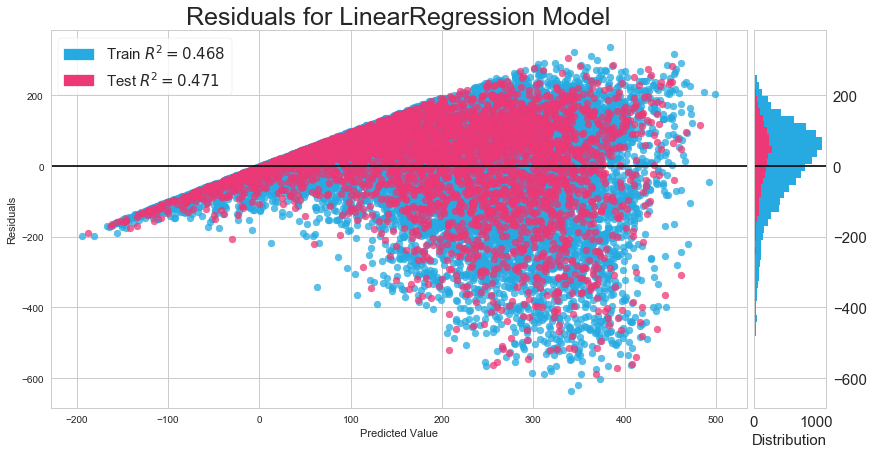

In [19]:
fig, ax = plt.subplots()
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
visualizer = ResidualsPlot(lr, train_color = '#26AAE1', test_color ='#EC3876', size = (1000,500),ax = ax)

visualizer.fit(train[features],train[target])  
visualizer.score(test[features], test[target])
visualizer.show()         

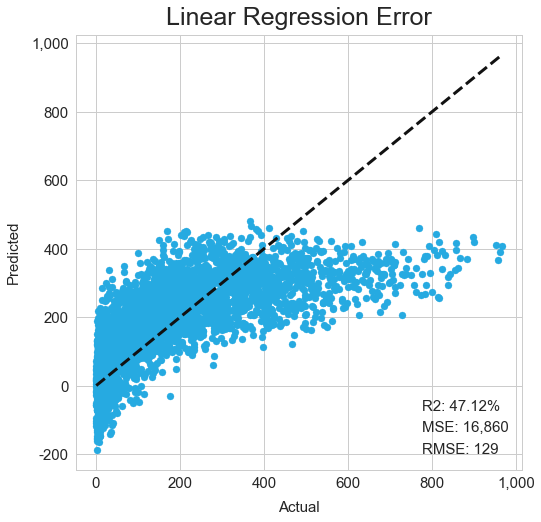

In [20]:
y = test[target]

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Linear Regression Error', size = 25, pad = 10)
ax.scatter(y, lr_predictions, color = '#26aae1')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Actual', size = 15, labelpad = 10)
ax.set_ylabel('Predicted', size = 15, labelpad = 10)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.yaxis.set_tick_params(labelsize=15)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 3
labels = []
labels.append("R2: " + str("{:.2%}".format(lr_r2)))
labels.append("MSE: " + str("{:,.0f}".format(lr_mse)))
labels.append("RMSE: " + str("{:,.0f}".format(lr_rmse)))
ax.legend(handles, labels, loc='lower right', fontsize=15, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)

plt.show()

With the average target value being roughly 180, 140 is a relatively high rmse. Lets see what the other models produce.

### Ridge Regression

In [21]:
# Ridge Regression model

rr = Ridge(random_state = 1)
rr.fit(train[features], train[target])
rr_predictions = rr.predict(test[features])
rr_r2 = r2_score(test[target], rr_predictions)
rr_mse = mean_squared_error(test[target], rr_predictions)
rr_rmse = int(rr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(rr_r2)))
print("MSE: " + str("{:,.0f}".format(rr_mse)))
print("RMSE: " + str("{:,.0f}".format(rr_rmse)))

R2: 47.12%
MSE: 16,861
RMSE: 129


In [22]:
#Optimized params for Ridge Regression Model

grid_object = GridSearchCV(rr, {'alpha':[0.0001,0.001,0.01,0.1,10,20,50,100]}, cv = 10)
grid_object.fit(train[features], train[target])
print("The most optimal parameters are:",grid_object.best_params_)

The most optimal parameters are: {'alpha': 0.1}


In [23]:
rr = Ridge(alpha = 10, random_state = 1)
rr.fit(train[features], train[target])
rr_predictions = rr.predict(test[features])
rr_r2 = r2_score(test[target], rr_predictions)
mse = mean_squared_error(test[target], rr_predictions)
rr_rmse = int(rr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(rr_r2)))
print("MSE: " + str("{:,.0f}".format(rr_mse)))
print("RMSE: " + str("{:,.0f}".format(rr_rmse)))

R2: 47.10%
MSE: 16,861
RMSE: 129


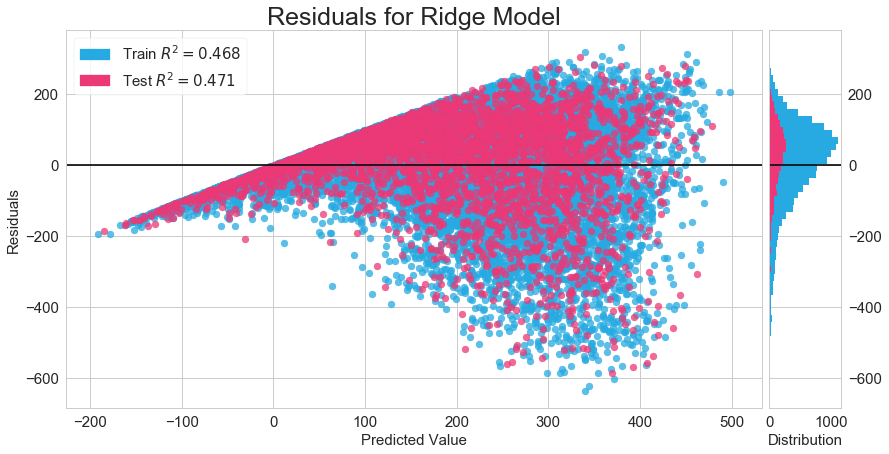

In [24]:
fig, ax = plt.subplots()
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
visualizer = ResidualsPlot(rr, train_color = '#26AAE1', test_color ='#EC3876', size = (1000,500),ax = ax)

visualizer.fit(train[features],train[target])  
visualizer.score(test[features], test[target])
visualizer.show()    

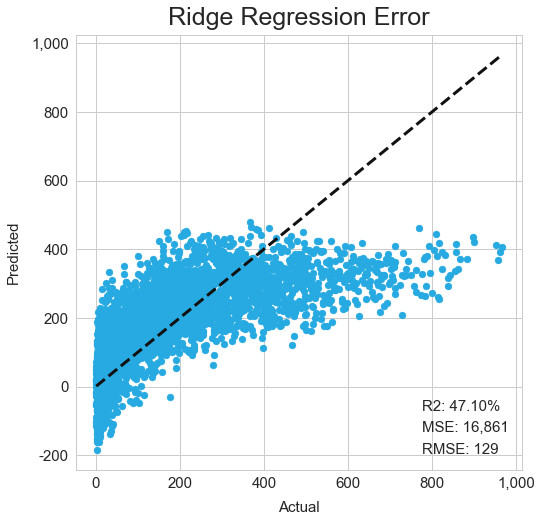

In [25]:
y = test[target]

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Ridge Regression Error', size = 25, pad = 10)
ax.scatter(y, rr_predictions, color = '#26aae1')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Actual', size = 15, labelpad = 10)
ax.set_ylabel('Predicted', size = 15, labelpad = 10)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.yaxis.set_tick_params(labelsize=15)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 3
labels = []
labels.append("R2: " + str("{:.2%}".format(rr_r2)))
labels.append("MSE: " + str("{:,.0f}".format(rr_mse)))
labels.append("RMSE: " + str("{:,.0f}".format(rr_rmse)))
ax.legend(handles, labels, loc='lower right', fontsize=15, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)

plt.show()

### Lasso Regression

In [26]:
# Lasso Regression model

lassor = Lasso(random_state = 1)
lassor.fit(train[features], train[target])
lassor_predictions = lassor.predict(test[features])
lassor_r2 = r2_score(test[target], lassor_predictions)
lassor_mse = mean_squared_error(test[target], lassor_predictions)
lassor_rmse = int(lassor_mse ** (1/2))

print("R2: " + str("{:.2%}".format(lassor_r2)))
print("MSE: " + str("{:,.0f}".format(lassor_mse)))
print("RMSE: " + str("{:,.0f}".format(lassor_rmse)))

R2: 46.80%
MSE: 16,964
RMSE: 130


In [27]:
#Optimized params for Lasso Regression

grid_object = GridSearchCV(rr, {'alpha':[0.0001,0.001,0.01,0.1,10,20,50,100]}, cv = 10)
grid_object.fit(train[features], train[target])
print("The most optimal parameters are:",grid_object.best_params_)

The most optimal parameters are: {'alpha': 0.1}


In [28]:
lassor = Lasso(alpha = 0.1, random_state = 1)
lassor.fit(train[features], train[target])
lassor_predictions = lassor.predict(test[features])
lassor_r2 = r2_score(test[target], lassor_predictions)
lassor_mse = mean_squared_error(test[target], lassor_predictions)
lassor_rmse = int(lassor_mse ** (1/2))

print("R2: " + str("{:.2%}".format(lassor_r2)))
print("MSE: " + str("{:,.0f}".format(lassor_mse)))
print("RMSE: " + str("{:,.0f}".format(lassor_rmse)))

R2: 47.12%
MSE: 16,863
RMSE: 129


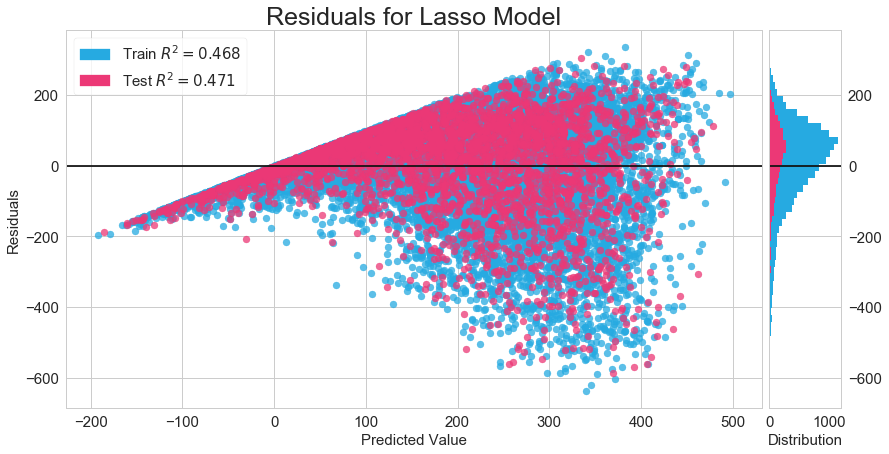

In [29]:
fig, ax = plt.subplots()
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
visualizer = ResidualsPlot(lassor, train_color = '#26AAE1', test_color ='#EC3876', size = (1000,500),ax = ax)

visualizer.fit(train[features],train[target])  
visualizer.score(test[features], test[target])
visualizer.show()    

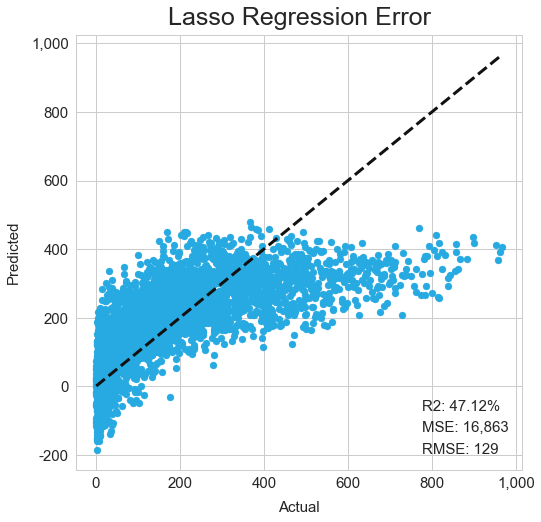

In [30]:
y = test[target]

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Lasso Regression Error', size = 25, pad = 10)
ax.scatter(y, lassor_predictions, color = '#26aae1')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Actual', size = 15, labelpad = 10)
ax.set_ylabel('Predicted', size = 15, labelpad = 10)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.yaxis.set_tick_params(labelsize=15)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 3
labels = []
labels.append("R2: " + str("{:.2%}".format(lassor_r2)))
labels.append("MSE: " + str("{:,.0f}".format(lassor_mse)))
labels.append("RMSE: " + str("{:,.0f}".format(lassor_rmse)))
ax.legend(handles, labels, loc='lower right', fontsize=15, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)

plt.show()

### Elastic-Net Regression

In [31]:
# Elastic-Net Regression model

enr = ElasticNet(random_state = 1)
enr.fit(train[features], train[target])
enr_predictions = enr.predict(test[features])
enr_r2 = r2_score(test[target], enr_predictions)
enr_mse = mean_squared_error(test[target], enr_predictions)
enr_rmse = int(enr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(enr_r2)))
print("MSE: " + str("{:,.0f}".format(enr_mse)))
print("RMSE: " + str("{:,.0f}".format(enr_rmse)))

R2: 18.90%
MSE: 25,860
RMSE: 160


In [32]:
#Optimized params for Elastic-Net Regression

grid_params = {'max_iter': [1, 5, 10, 50, 100], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'l1_ratio': np.arange(0.0, 1.0, 0.1)}
grid_object = GridSearchCV(estimator = enr, param_grid = grid_params, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = -1)
grid_object.fit(train[features], train[target])
print("The most optimal parameters are:",grid_object.best_params_)

The most optimal parameters are: {'alpha': 0.001, 'l1_ratio': 0.5, 'max_iter': 100}


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120247825.67469445, tolerance: 46092.17534415594
  positive)


In [33]:
enr = ElasticNet(alpha = 0.1, l1_ratio = 0.8, max_iter = 10, random_state = 1)
enr.fit(train[features], train[target])
enr_predictions = enr.predict(test[features])
enr_r2 = r2_score(test[target], enr_predictions)
enr_mse = mean_squared_error(test[target], enr_predictions)
enr_rmse = int(enr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(enr_r2)))
print("MSE: " + str("{:,.0f}".format(enr_mse)))
print("RMSE: " + str("{:,.0f}".format(enr_rmse)))

R2: 45.94%
MSE: 17,238
RMSE: 131


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216489.6500132084, tolerance: 46092.17534415594
  positive)


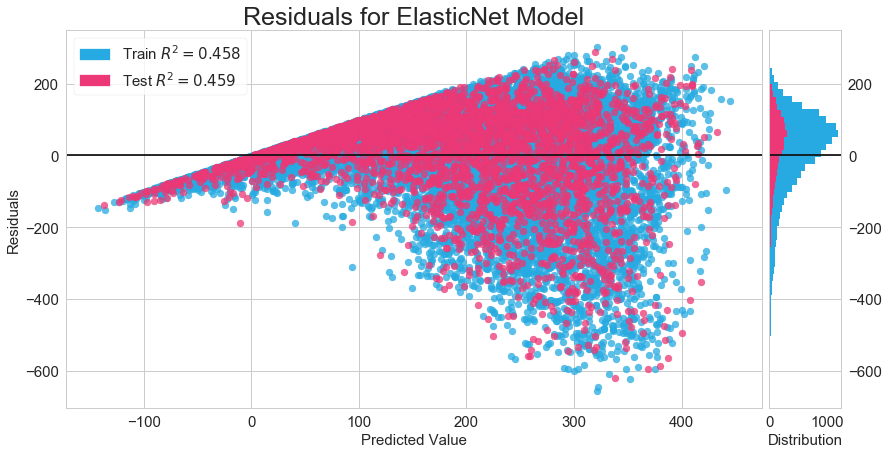

In [34]:
fig, ax = plt.subplots()
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
visualizer = ResidualsPlot(enr, train_color = '#26AAE1', test_color ='#EC3876', size = (1000,500),ax = ax)

visualizer.fit(train[features],train[target])  
visualizer.score(test[features], test[target])
visualizer.show()  

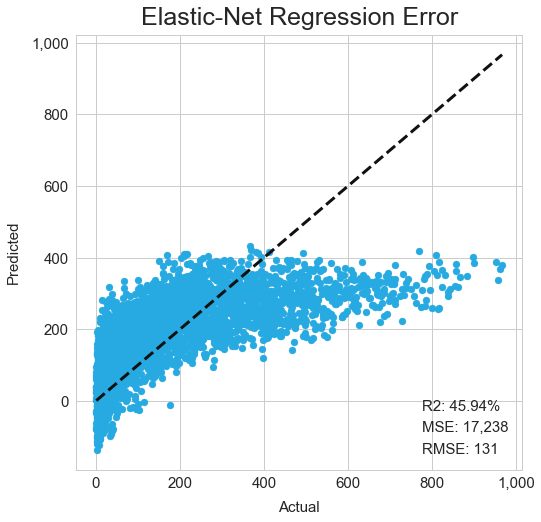

In [35]:
y = test[target]

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Elastic-Net Regression Error', size = 25, pad = 10)
ax.scatter(y, enr_predictions, color = '#26aae1')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Actual', size = 15, labelpad = 10)
ax.set_ylabel('Predicted', size = 15, labelpad = 10)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.yaxis.set_tick_params(labelsize=15)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 3
labels = []
labels.append("R2: " + str("{:.2%}".format(enr_r2)))
labels.append("MSE: " + str("{:,.0f}".format(enr_mse)))
labels.append("RMSE: " + str("{:,.0f}".format(enr_rmse)))
ax.legend(handles, labels, loc='lower right', fontsize=15, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)

plt.show()

### Decision Tree Regressor

In [36]:
# Decision Tree Regressor model

dtr = DecisionTreeRegressor(random_state = 1)
dtr.fit(train[features], train[target])
dtr_predictions = dtr.predict(test[features])
dtr_r2 = r2_score(test[target], dtr_predictions)
dtr_mse = mean_squared_error(test[target], dtr_predictions)
dtr_rmse = int(dtr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(dtr_r2)))
print("MSE: " + str("{:,.0f}".format(dtr_mse)))
print("RMSE: " + str("{:,.0f}".format(dtr_rmse)))

R2: 90.92%
MSE: 2,895
RMSE: 129


In [37]:
#Optimized params for Decision Tree Regressor

grid_params = {'max_depth': [1,3,50,100], 'min_samples_leaf': [2,5,10,50]}
grid_object = GridSearchCV(estimator = dtr, param_grid = grid_params, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = -1)
grid_object.fit(train[features], train[target])
print("The most optimal parameters are:",grid_object.best_params_)

The most optimal parameters are: {'max_depth': 50, 'min_samples_leaf': 5}


Will adjust next model iteration to use these params

In [38]:
#Optimized params for Decision Tree Regressor

grid_params = {'splitter': ['best','random'], 'max_features': [None, 'auto'],'criterion':['mse','friedman_mse']}
grid_object = GridSearchCV(estimator = dtr, param_grid = grid_params, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = -1)
grid_object.fit(train[features], train[target])
print("The most optimal parameters are:",grid_object.best_params_)

The most optimal parameters are: {'criterion': 'mse', 'max_features': None, 'splitter': 'best'}


These were the default params so will keep these.

In [39]:
dtr = DecisionTreeRegressor(max_depth = 100, min_samples_leaf = 5, criterion = 'friedman_mse', random_state = 1)
dtr.fit(train[features], train[target])
dtr_predictions = dtr.predict(test[features])
dtr_r2 = r2_score(test[target], dtr_predictions)
mse = mean_squared_error(test[target], dtr_predictions)
dtr_rmse = int(dtr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(dtr_r2)))
print("MSE: " + str("{:,.0f}".format(dtr_mse)))
print("RMSE: " + str("{:,.0f}".format(dtr_rmse)))

R2: 91.82%
MSE: 2,895
RMSE: 53


These model optimizations we made improved the accuracy of the decision tree regressor by 12%

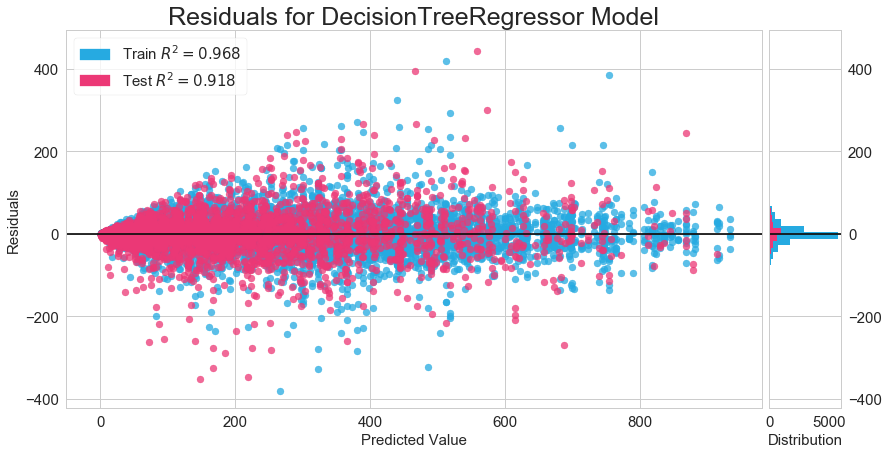

In [40]:
fig, ax = plt.subplots()
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
visualizer = ResidualsPlot(dtr, train_color = '#26AAE1', test_color ='#EC3876', size = (1000,500),ax = ax)

visualizer.fit(train[features],train[target])  
visualizer.score(test[features], test[target])
visualizer.show()    

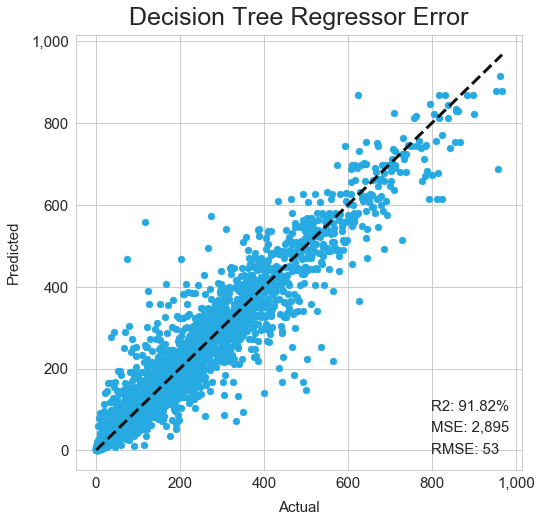

In [41]:
y = test[target]

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Decision Tree Regressor Error', size = 25, pad = 10)
ax.scatter(y, dtr_predictions, color = '#26aae1')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Actual', size = 15, labelpad = 10)
ax.set_ylabel('Predicted', size = 15, labelpad = 10)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.yaxis.set_tick_params(labelsize=15)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 3
labels = []
labels.append("R2: " + str("{:.2%}".format(dtr_r2)))
labels.append("MSE: " + str("{:,.0f}".format(dtr_mse)))
labels.append("RMSE: " + str("{:,.0f}".format(dtr_rmse)))
ax.legend(handles, labels, loc='lower right', fontsize=15, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)

plt.show()

### Random Forest Regression Tree

In [42]:
# Random Forest Regressor model

rfr = RandomForestRegressor(random_state = 1)
rfr.fit(train[features], train[target])
rfr_predictions = rfr.predict(test[features])
rfr_r2 = r2_score(test[target], rfr_predictions)
rfr_mse = mean_squared_error(test[target], rfr_predictions)
rfr_rmse = int(rfr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(rfr_r2)))
print("MSE: " + str("{:,.0f}".format(rfr_mse)))
print("RMSE: " + str("{:,.0f}".format(rfr_rmse)))

R2: 94.48%
MSE: 1,759
RMSE: 51


In [43]:
#Optimized params for Random Forest Regressor

grid_params = {'min_samples_leaf': [2,5,10,15],
               'min_samples_split': [2,5,10,15],
               'max_depth': [5,6,10,25],
               'max_leaf_nodes': [5,10,20,50]}
grid_object = GridSearchCV(estimator = rfr, param_grid = grid_params, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = -1)
grid_object.fit(train[features], train[target])
print("The most optimal parameters are:",grid_object.best_params_)

The most optimal parameters are: {'max_depth': 10, 'max_leaf_nodes': 50, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [44]:
#Optimized params for Random Forest Regressor

grid_params = {'warm_start': [True, False], 'bootstrap': [True, False], 'max_features':['auto',None]}
grid_object = GridSearchCV(estimator = rfr, param_grid = grid_params, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = -1)
grid_object.fit(train[features], train[target])
print("The most optimal parameters are:",grid_object.best_params_)

The most optimal parameters are: {'bootstrap': True, 'max_features': 'auto', 'warm_start': True}


I got this version of the model after further optimizaing params by hand

In [78]:
# Random Forest Regressor model

rfr = RandomForestRegressor(max_depth = 20, max_leaf_nodes = 2000, min_samples_leaf = 2,
                            min_samples_split = 5, n_estimators = 100, random_state = 1)
rfr.fit(train[features], train[target])
rfr_predictions = rfr.predict(test[features])
rfr_r2 = r2_score(test[target], rfr_predictions)
rfr_mse = mean_squared_error(test[target], rfr_predictions)
rfr_rmse = int(rfr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(rfr_r2)))
print("MSE: " + str("{:,.0f}".format(rfr_mse)))
print("RMSE: " + str("{:,.0f}".format(rfr_rmse)))

R2: 95.00%
MSE: 1,595
RMSE: 51


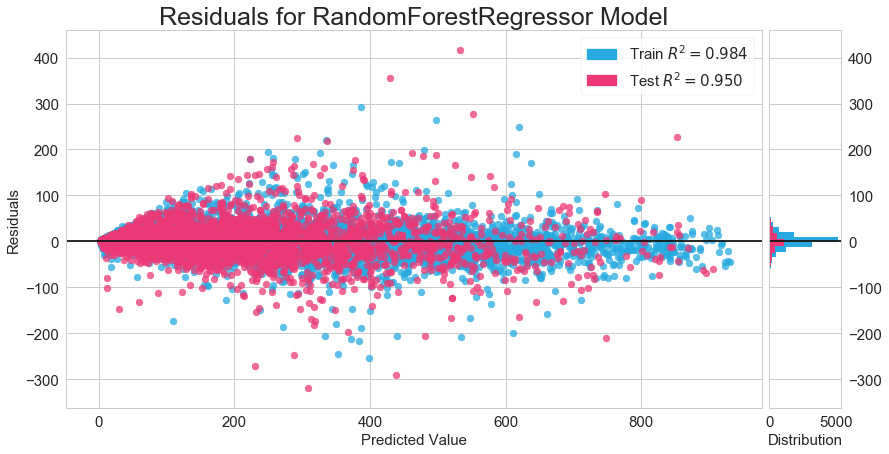

In [79]:
fig, ax = plt.subplots()
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
visualizer = ResidualsPlot(rfr, train_color = '#26AAE1', test_color ='#EC3876', size = (1000,500),ax = ax)

visualizer.fit(train[features],train[target])  
visualizer.score(test[features], test[target])
visualizer.show()    

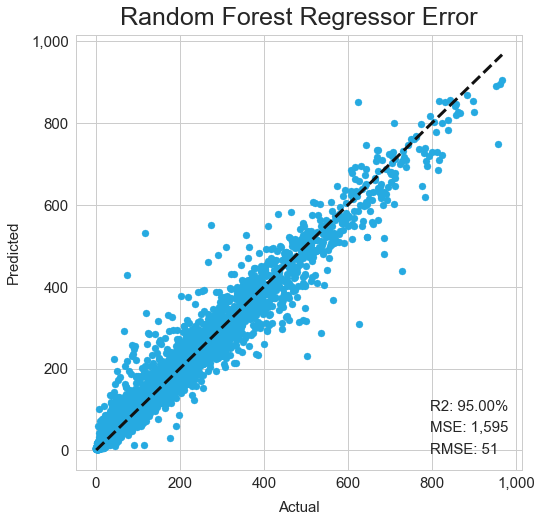

In [80]:
y = test[target]

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Random Forest Regressor Error', size = 25, pad = 10)
ax.scatter(y, rfr_predictions, color = '#26aae1')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Actual', size = 15, labelpad = 10)
ax.set_ylabel('Predicted', size = 15, labelpad = 10)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.yaxis.set_tick_params(labelsize=15)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 3
labels = []
labels.append("R2: " + str("{:.2%}".format(rfr_r2)))
labels.append("MSE: " + str("{:,.0f}".format(rfr_mse)))
labels.append("RMSE: " + str("{:,.0f}".format(rfr_rmse)))
ax.legend(handles, labels, loc='lower right', fontsize=15, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)

plt.show()

### AdaBoost Tree

In [85]:
# AdaBoost Regressor model

abr = AdaBoostRegressor(random_state = 1)
abr.fit(train[features], train[target])
abr_predictions = abr.predict(test[features])
abr_r2 = r2_score(test[target], abr_predictions)
abr_mse = mean_squared_error(test[target], abr_predictions)
abr_rmse = int(abr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(abr_r2)))
print("MSE: " + str("{:,.0f}".format(abr_mse)))
print("RMSE: " + str("{:,.0f}".format(abr_rmse)))

R2: 65.04%
MSE: 11,149
RMSE: 105


In [89]:
#Optimized params for AdaBoost Regressor

grid_params = {'learning_rate':[0.01,0.05,0.1,0.25,0.5], 'loss': ['linear','square','exponential']}
grid_object = GridSearchCV(estimator = abr, param_grid = grid_params, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = -1)
grid_object.fit(train[features], train[target])
print("The most optimal parameters are:",grid_object.best_params_)

The most optimal parameters are: {'learning_rate': 0.5, 'loss': 'square'}


In [91]:
# AdaBoost Regressor model

abr = AdaBoostRegressor(learning_rate = 0.5, loss = 'square', n_estimators = 150, random_state = 1)
abr.fit(train[features], train[target])
abr_predictions = abr.predict(test[features])
abr_r2 = r2_score(test[target], abr_predictions)
abr_mse = mean_squared_error(test[target], abr_predictions)
abr_rmse = int(abr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(abr_r2)))
print("MSE: " + str("{:,.0f}".format(abr_mse)))
print("RMSE: " + str("{:,.0f}".format(abr_rmse)))

R2: 67.78%
MSE: 10,275
RMSE: 101


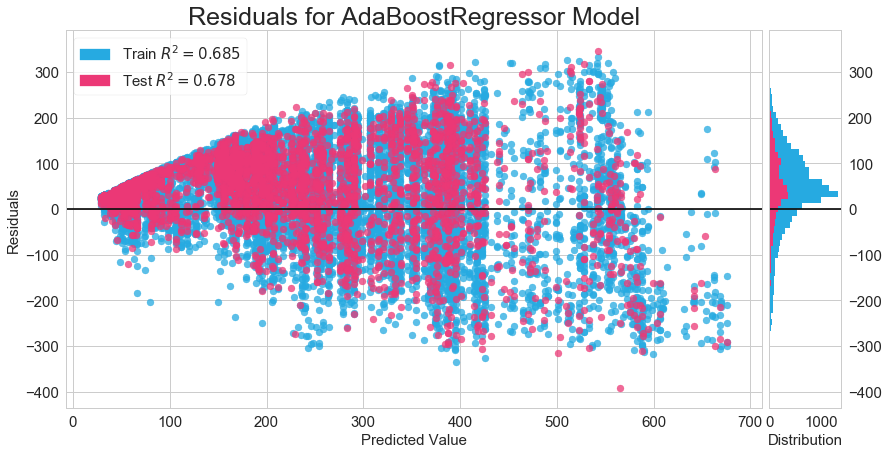

In [92]:
fig, ax = plt.subplots()
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
visualizer = ResidualsPlot(abr, train_color = '#26AAE1', test_color ='#EC3876', size = (1000,500),ax = ax)

visualizer.fit(train[features],train[target])  
visualizer.score(test[features], test[target])
visualizer.show()    

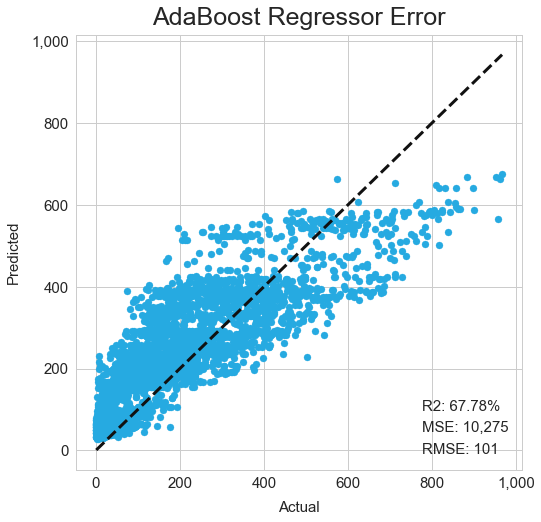

In [93]:
y = test[target]

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('AdaBoost Regressor Error', size = 25, pad = 10)
ax.scatter(y, abr_predictions, color = '#26aae1')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Actual', size = 15, labelpad = 10)
ax.set_ylabel('Predicted', size = 15, labelpad = 10)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.yaxis.set_tick_params(labelsize=15)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 3
labels = []
labels.append("R2: " + str("{:.2%}".format(abr_r2)))
labels.append("MSE: " + str("{:,.0f}".format(abr_mse)))
labels.append("RMSE: " + str("{:,.0f}".format(abr_rmse)))
ax.legend(handles, labels, loc='lower right', fontsize=15, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)

plt.show()

### Gradient Boosted Tree

In [96]:
# Gradient Boosted Regressor model

gbr = GradientBoostingRegressor(random_state = 1)
gbr.fit(train[features], train[target])
gbr_predictions = gbr.predict(test[features])
gbr_r2 = r2_score(test[target], gbr_predictions)
gbr_mse = mean_squared_error(test[target], gbr_predictions)
gbr_rmse = int(gbr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(gbr_r2)))
print("MSE: " + str("{:,.0f}".format(gbr_mse)))
print("RMSE: " + str("{:,.0f}".format(gbr_rmse)))

R2: 86.09%
MSE: 4,435
RMSE: 66


In [101]:
#Optimized params for Gradient Boosted Regressor

grid_params = {
    'max_depth': [5,10,15,25,50], 
    'min_samples_leaf': [2,3,4,5,10],
    'learning_rate': [0.1,0.25,0.5,0.75],
    'subsample': [0.1,0.25,0.5,0.75]
}
grid_object = GridSearchCV(estimator = gbr, param_grid = grid_params, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = -1)
grid_object.fit(train[features], train[target])
print("The most optimal parameters are:",grid_object.best_params_)

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The most optimal parameters are: {'learning_rate': 0.1, 'max_depth': 25, 'min_samples_leaf': 10, 'subsample': 0.75}


In [104]:
#Optimized params for Gradient Boosted Regressor

grid_params = {
    'min_samples_leaf': [2,5,10,15,25], 
    'min_weight_fraction_leaf': [0,0.1,0.2,0.3,0.5,],
    'min_impurity_decrease': [0,0.1,0.2,0.5,1]
}
grid_object = GridSearchCV(estimator = gbr, param_grid = grid_params, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = -1)
grid_object.fit(train[features], train[target])
print("The most optimal parameters are:",grid_object.best_params_)

The most optimal parameters are: {'min_impurity_decrease': 0, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0}


In [106]:
#Optimized params for Gradient Boosted Regressor

grid_params = {
    'loss': ['ls','lad','huber','quantile'],
    'criterion': ['friedman_mse','mse']
}
grid_object = GridSearchCV(estimator = gbr, param_grid = grid_params, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = -1)
grid_object.fit(train[features], train[target])
print("The most optimal parameters are:",grid_object.best_params_)

The most optimal parameters are: {'criterion': 'friedman_mse', 'loss': 'ls'}


In [108]:
# Optimized Gradient Boosted Regressor model

gbr = GradientBoostingRegressor(learning_rate =  0.1, max_depth =  25, min_samples_leaf =  10, 
                                subsample =  0.75, min_impurity_decrease =  0,  min_weight_fraction_leaf =  0, 
                                criterion =  'friedman_mse', loss =  'ls',  random_state = 1)
gbr.fit(train[features], train[target])
gbr_predictions = gbr.predict(test[features])
gbr_r2 = r2_score(test[target], gbr_predictions)
gbr_mse = mean_squared_error(test[target], gbr_predictions)
gbr_rmse = int(gbr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(gbr_r2)))
print("MSE: " + str("{:,.0f}".format(gbr_mse)))
print("RMSE: " + str("{:,.0f}".format(gbr_rmse)))

R2: 96.20%
MSE: 1,213
RMSE: 34


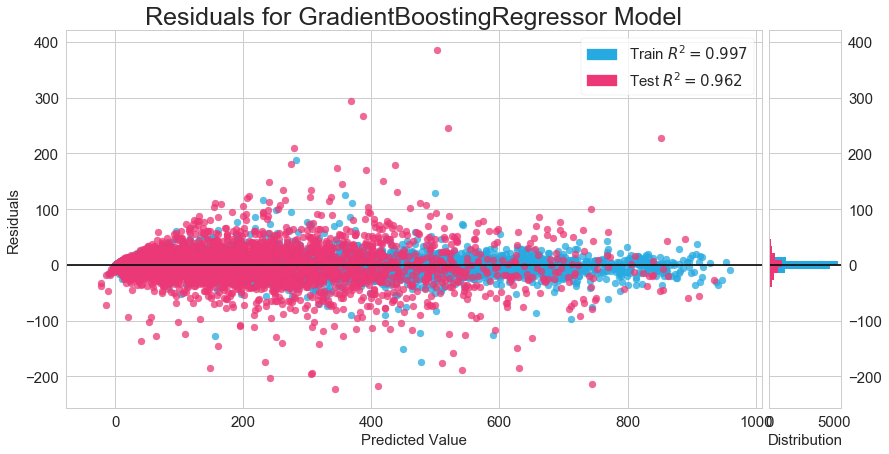

In [109]:
fig, ax = plt.subplots()
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
visualizer = ResidualsPlot(gbr, train_color = '#26AAE1', test_color ='#EC3876', size = (1000,500),ax = ax)

visualizer.fit(train[features],train[target])  
visualizer.score(test[features], test[target])
visualizer.show()    

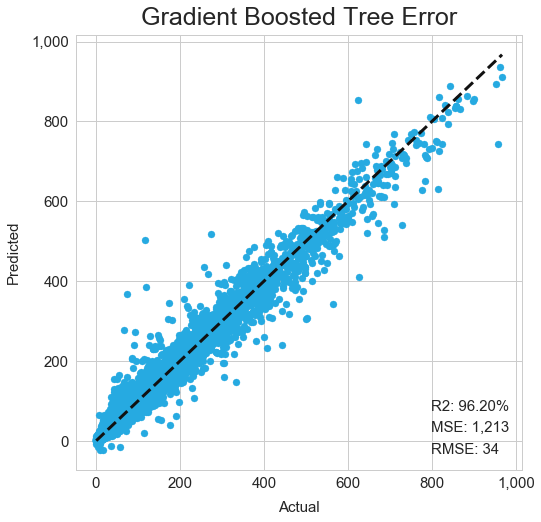

In [111]:
y = test[target]

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Gradient Boosted Tree Error', size = 25, pad = 10)
ax.scatter(y, gbr_predictions, color = '#26aae1')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Actual', size = 15, labelpad = 10)
ax.set_ylabel('Predicted', size = 15, labelpad = 10)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.yaxis.set_tick_params(labelsize=15)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 3
labels = []
labels.append("R2: " + str("{:.2%}".format(gbr_r2)))
labels.append("MSE: " + str("{:,.0f}".format(gbr_mse)))
labels.append("RMSE: " + str("{:,.0f}".format(gbr_rmse)))
ax.legend(handles, labels, loc='lower right', fontsize=15, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)

plt.show()

### Support Vector Regressor

In [279]:
# Support Vector Regressor model

svr = SVR()
svr.fit(train[features], train[target])
svr_predictions = svr.predict(test[features])
svr_r2 = r2_score(test[target], svr_predictions)
svr_mse = mean_squared_error(test[target], svr_predictions)
svr_rmse = int(svr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(svr_r2)))
print("MSE: " + str("{:,.0f}".format(svr_mse)))
print("RMSE: " + str("{:,.0f}".format(svr_rmse)))

R2: 31.43%
MSE: 21,864
RMSE: 147


In [286]:
#Optimized params for Support Vector Regressor

grid_params = {
    'kernel': ['linear', 'poly'], 
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False],
}
grid_object = GridSearchCV(estimator = svr, param_grid = grid_params, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = -1)
grid_object.fit(train[features], train[target])
print("The most optimal parameters are:",grid_object.best_params_)

The most optimal parameters are: {'gamma': 'scale', 'kernel': 'poly', 'shrinking': True}


In [288]:
#Optimized params for Support Vector Regressor

grid_params = {
    'coef0': [0.0, 0.1, 0.25, 0.5], 
    'C': [1.0, 0.75, 0.5, 0.25],
    'epsilon': [0.1, 0.25, 0.5, 0.75],
}

svr = SVR(gamma = 'scale', kernel = 'poly', shrinking = True)
grid_object = GridSearchCV(estimator = svr, param_grid = grid_params, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = -1)
grid_object.fit(train[features], train[target])
print("The most optimal parameters are:",grid_object.best_params_)

The most optimal parameters are: {'C': 1.0, 'coef0': 0.5, 'epsilon': 0.75}


### MultiLayer Perceptron (Artifical Neural Network)

In [115]:
# Multilayer Perceptron Regressor model

mlpr = MLPRegressor(random_state = 1)
mlpr.fit(train[features], train[target])
mlpr_predictions = mlpr.predict(test[features])
mlpr_r2 = r2_score(test[target], mlpr_predictions)
mlpr_mse = mean_squared_error(test[target], mlpr_predictions)
mlpr_rmse = int(mlpr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(mlpr_r2)))
print("MSE: " + str("{:,.0f}".format(mlpr_mse)))
print("RMSE: " + str("{:,.0f}".format(mlpr_rmse)))

R2: 57.43%
MSE: 13,573
RMSE: 116


//anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [122]:
#Optimized params for Mulitlayer Perceptron Regressor

grid_params = {
    'hidden_layer_sizes': [2,5,10,15,25,100], 
    'learning_rate_init': [0.1,0.2,0.3,0.5,0.9],
    'momentum': [0.1,0.2,0.5,0.75],
    'alpha': [0.0001,0.001,0.01,0.1]
}
grid_object = GridSearchCV(estimator = mlpr, param_grid = grid_params, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = -1)
grid_object.fit(train[features], train[target])
print("The most optimal parameters are:",grid_object.best_params_)

The most optimal parameters are: {'alpha': 0.0001, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.3, 'momentum': 0.1}


In [123]:
#Optimized params for Mulitlayer Perceptron Regressor

grid_params = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'], 
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'warm_start': [True, False]
}
grid_object = GridSearchCV(estimator = mlpr, param_grid = grid_params, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = -1)
grid_object.fit(train[features], train[target])
print("The most optimal parameters are:",grid_object.best_params_)

The most optimal parameters are: {'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'sgd', 'warm_start': True}


//anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [128]:
# Optimized Multilayer Perceptron Regressor model

mlpr = MLPRegressor(alpha =  0.0001, hidden_layer_sizes =  100, learning_rate_init =  0.3, 
                    momentum =  0.1, activation =  'tanh', learning_rate =  'adaptive', 
                    warm_start =  True, random_state = 1)
mlpr.fit(train[features], train[target])
mlpr_predictions = mlpr.predict(test[features])
mlpr_r2 = r2_score(test[target], mlpr_predictions)
mlpr_mse = mean_squared_error(test[target], mlpr_predictions)
mlpr_rmse = int(mlpr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(mlpr_r2)))
print("MSE: " + str("{:,.0f}".format(mlpr_mse)))
print("RMSE: " + str("{:,.0f}".format(mlpr_rmse)))

R2: 75.69%
MSE: 7,750
RMSE: 88


### Model Stacking Regressor

In [272]:
# Model Stacking Regression model

rr = Ridge(alpha = 10, random_state = 1)
dtr =  DecisionTreeRegressor(max_depth = 100, min_samples_leaf = 5, criterion = 'friedman_mse', random_state = 1)
mlpr = MLPRegressor(alpha =  0.0001, hidden_layer_sizes =  100, learning_rate_init =  0.3, 
                    momentum =  0.1, activation =  'tanh', learning_rate =  'adaptive', 
                    warm_start =  True, random_state = 1)
rfr = RandomForestRegressor(max_depth = 20, max_leaf_nodes = 2000, min_samples_leaf = 2,
                            min_samples_split = 5, n_estimators = 100, random_state = 1)


msr = StackingRegressor(regressors=[lr, rr, dtr, gbr], meta_regressor=rfr)
msr.fit(train[features], train[target])
msr_predictions = msr.predict(test[features])
msr_r2 = r2_score(test[target], msr_predictions)
msr_mse = mean_squared_error(test[target], msr_predictions)
msr_rmse = int(msr_mse ** (1/2))

print("R2: " + str("{:.2%}".format(msr_r2)))
print("MSE: " + str("{:,.0f}".format(msr_mse)))
print("RMSE: " + str("{:,.0f}".format(msr_rmse)))

R2: 96.21%
MSE: 1,208
RMSE: 34


## Model Evaluation

In [273]:
model_list = ['Linear Regression','Ridge Regression','Lasso Regression','Elastic-Net Regression','Decision-Tree Regressor','Random Forest Regression Tree','AdaBoost Regression Tree','Gradient Boosted Regression Tree','MultiLayer Perceptron Regressor','Model Stacking Regressor']
r2_list = [lr_r2,rr_r2,lassor_r2,enr_r2,dtr_r2,rfr_r2,abr_r2,gbr_r2,mlpr_r2,msr_r2]
mse_list = [lr_mse,rr_mse,lassor_mse,enr_mse,dtr_mse,rfr_mse,abr_mse,gbr_mse,mlpr_mse,msr_mse]
rmse_list = [lr_rmse,rr_rmse,lassor_rmse,enr_rmse,dtr_rmse,rfr_rmse,abr_rmse,gbr_rmse,mlpr_rmse,msr_rmse]

model_eval = pd.DataFrame()
model_eval['Models'] = model_list
model_eval['R2'] = r2_list
model_eval['MSE'] = mse_list
model_eval['RMSE'] = rmse_list
model_eval['MSE'] = model_eval['MSE'].astype(int)
model_eval['RMSE'] = model_eval['RMSE'].astype(int)

In [274]:
#Scaling for Evaluation

model_eval_scaled = pd.DataFrame()
numeric_cols = model_eval.select_dtypes(include=['int', 'float'])
numeric_cols = numeric_cols.columns
model_eval_scaled[numeric_cols] = model_eval[numeric_cols].astype(float)
model_eval_scaled = model_eval[numeric_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
model_eval_scaled['MSE'] = 1 - model_eval_scaled['MSE']
model_eval_scaled = pd.concat([model_eval['Models'], model_eval_scaled[['R2','MSE']]], axis=1)
model_eval_scaled['Score'] = model_eval_scaled['R2'] + model_eval_scaled['MSE']
model_eval_scaled['Rank'] = model_eval_scaled['Score'].rank(ascending = False).astype(int)
model_eval_scaled['Rank'] = model_eval_scaled['Score'].rank(ascending = False).astype(int)
model_eval['Rank'] = model_eval_scaled['Rank']

In [275]:
model_eval = model_eval.sort_values('Rank',ascending = True)
model_eval.style.background_gradient(cmap='Blues', subset=['R2']).background_gradient(cmap=plt.cm.get_cmap('Blues_r'), subset=['MSE','RMSE','Rank'])

## Conclusion

When evaluating models it is important to understand how they will be deployed. In this case the Model Stacking Regressor was the best predictor overall and would be the best pick if our only concern was getting the most accurate predictor possible. If we wanted to see the regression coefficients to see which features were most important in making the prediction then we would choose the Gradient Boosted Regression Tree. If interpretability was important and we would be presenting the models decision making in a business meeting than we would choose the most accurate but readable model which would be the Decision Tree Regressor in this case.